# Analyze of Dicom files

In [1]:
import os 
import cv2
import pydicom
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Path of dicom files
file1 = "I0000001"
file2 = "I0000001 copie"

In [3]:
def store2txt(dicom_file, txtname = "dicom_info"):
    """This function extract and store the metadata in a txt file"""
    with open(f"{txtname}.txt", "w") as f:
        for element in tqdm(dicom_file, desc = "Extraction"):
            f.write(f"{element.tag} - {element.name}: {element.value}\n")

In [4]:
def imshow_dicom(file):
    """Show dicom images"""
    name = os.path.basename(file)
    img = pydicom.dcmread(file)
    arr = img.pixel_array
    plt.title(f"Image: {name}")
    plt.axis("off")
    plt.imshow(arr, cmap = "gray")

In [5]:
img1 = pydicom.dcmread(file1)
store2txt(img1)

Extraction:   0%|          | 0/57 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/pydicom/hooks.py:199: UserWarning: VR lookup failed for the raw element with tag (1500,0600) - setting VR to 'UN'
  warn_and_log(f"{msg} - setting VR to 'UN'")
Extraction: 100%|██████████| 57/57 [00:00<00:00, 607.69it/s]


In [6]:
arr1 = img1.pixel_array
plt.axis("off")
plt.imshow(arr1, cmap = "gray")

AttributeError: The dataset has no 'Pixel Data', 'Float Pixel Data' or 'Double Float Pixel Data' element, no pixel data to decode

```Unfortunately I have found a dicom file without Pixel Data. I think all data have values. We will process a function which can analyzes and return all dicom file with pixel array which can be manipulate```

In [7]:
def check_pixeldata(path, verbose = True):
    """Function used to check if in a dicom file we have Pixel Data"""
    if os.path.isdir(path):
        print("The path provide is a folder")
        ok_path = list()
        notok_path = list()
        for i in tqdm(range(len(os.listdir(path)))):
            f = os.listdir(path)[i]
            f = os.path.join(path, f)
            x = pydicom.dcmread(f)
            if 'PixelData' in x:
                if verbose:
                    print(f"{f} contains pixel values. OK")
                ok_path.append(f)
            else:
                if verbose:
                    print(f"{f} don't provide pixel values!!! Not OK!")
                notok_path.append(f)
        print(f"We have {len(ok_path)} dicom files with pixel values and {len(notok_path)} without pixel values")
        return ok_path, notok_path
    else:
        x = pydicom.dcmread(path)
        if 'PixelData' in x:
            print(f"{path} contains pixel values. OK")
        else:
            print(f"{path} don't provide pixel values!!! Not OK!")

In [8]:
check_pixeldata(path = file2)

I0000001 copie don't provide pixel values!!! Not OK!


In [9]:
# Annotations images
goodlist, badlist = check_pixeldata(path = "/Users/armandbryan/Documents/aivancity/PGE5/Medical AI/Project/Data/Data/OK_annotations", verbose = False)

The path provide is a folder


100%|██████████| 940/940 [00:06<00:00, 138.83it/s]

We have 904 dicom files with pixel values and 36 without pixel values


In [10]:
# OK images
goodlist_2, badlist_2 = check_pixeldata(path = "/Users/armandbryan/Documents/aivancity/PGE5/Medical AI/Project/Data/Data/OK_images", verbose = False)

The path provide is a folder


100%|██████████| 203/203 [00:01<00:00, 139.72it/s]

We have 189 dicom files with pixel values and 14 without pixel values


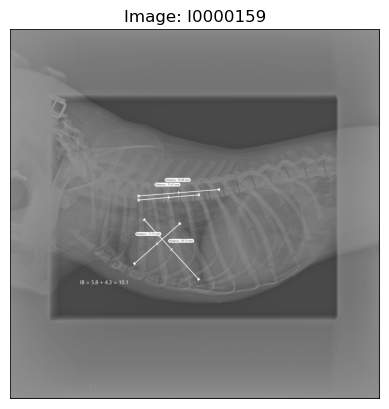

In [11]:
# Test 
imshow_dicom(goodlist[0])

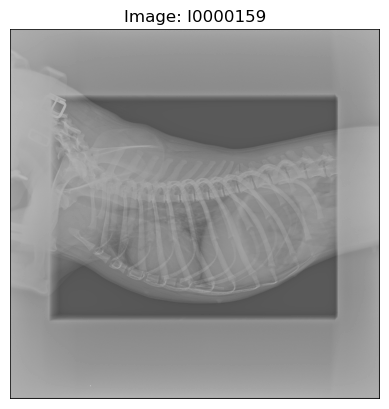

In [12]:
imshow_dicom(goodlist_2[0])

Good good good 

Let's see the metadata contains in this dicom file

In [13]:
store2txt(dicom_file = pydicom.dcmread(goodlist[0]), txtname = "good")

Extraction: 100%|██████████| 131/131 [00:00<00:00, 1363.19it/s]


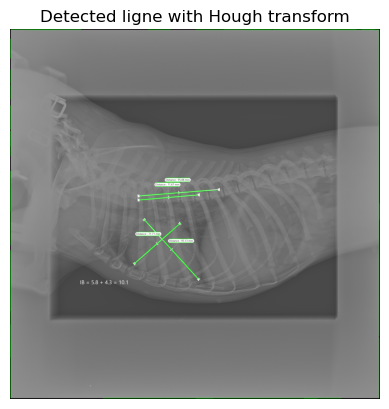

In [42]:
x = pydicom.dcmread(goodlist[0])
x_val = x.pixel_array

if x_val.max() > 255:
    x_val = (x_val / x_val.max()) * 255
x_val = x_val.astype(np.uint8)

edges = cv2.Canny(x_val, 50, 150, apertureSize = 3)
lines = cv2.HoughLinesP(edges, rho = 1, theta = np.pi/180, 
                        threshold = 100, minLineLength = 100, maxLineGap = 10)
image_lines = cv2.cvtColor(x_val, cv2.COLOR_GRAY2BGR)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_lines, (x1, y1), (x2, y2), (0, 255, 0), 2) 

plt.imshow(cv2.cvtColor(image_lines, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detected ligne with Hough transform")
plt.show()